In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/bidirectional_dropout.h5'
modeloSave='/transfer_bidirectional_dropout_balanceado.h5'

In [5]:
balanceo='_down_equals'

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [7]:
paciente='paciente3'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

5427

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

5427

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

384

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

384

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

3586

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

3586

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

113/113 [==============================] - 2s 9ms/step


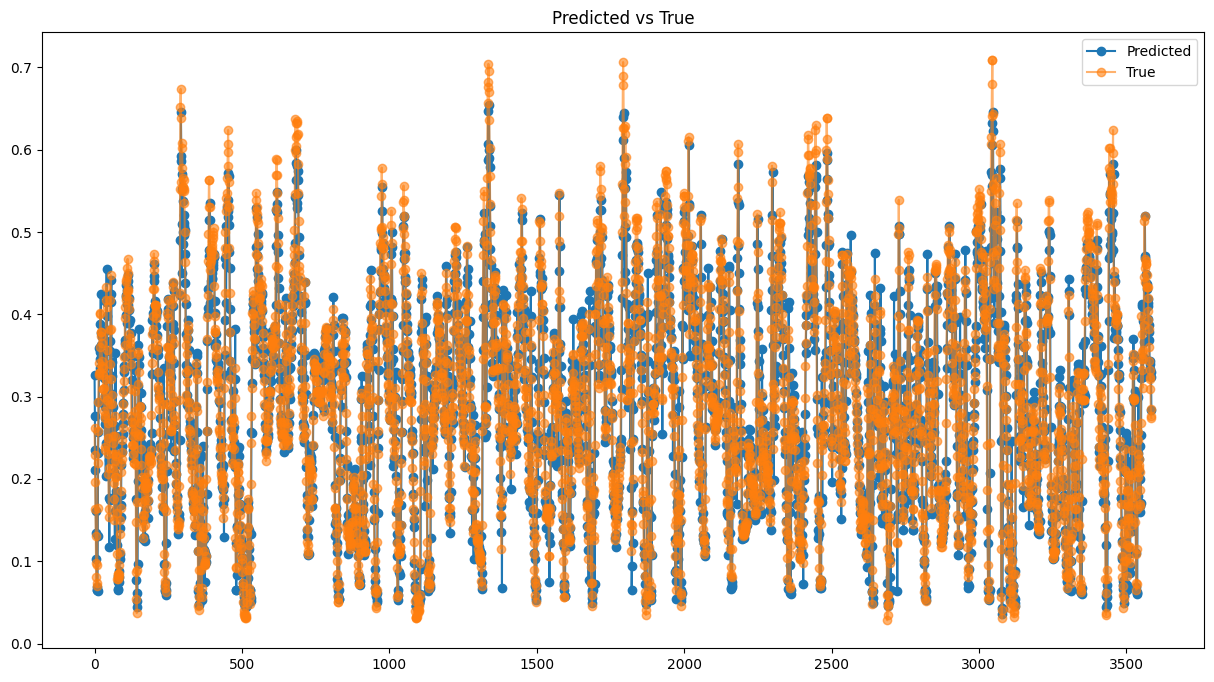

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03575072192062006,
 'mse': 0.04972010678851249,
 'rmse': 0.002472089019061086}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                      

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_8')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-3,True,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_input (InputL  [(None, 30, 5)]          0         
 ayer)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080  

In [27]:
array_Xtrain.shape

(5427, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
170/170 [==============================] - 8s 25ms/step - loss: 0.0069 - mae: 0.0573 - mse: 0.0069 - val_loss: 0.0030 - val_mae: 0.0375 - val_mse: 0.0030
Epoch 2/100
170/170 [==============================] - 3s 15ms/step - loss: 0.0032 - mae: 0.0387 - mse: 0.0032 - val_loss: 0.0018 - val_mae: 0.0304 - val_mse: 0.0018
Epoch 3/100
170/170 [==============================] - 3s 16ms/step - loss: 0.0033 - mae: 0.0379 - mse: 0.0033 - val_loss: 0.0019 - val_mae: 0.0302 - val_mse: 0.0019
Epoch 4/100
170/170 [==============================] - 3s 15ms/step - loss: 0.0028 - mae: 0.0364 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0273 - val_mse: 0.0015
Epoch 5/100
170/170 [==============================] - 2s 15ms/step - loss: 0.0027 - mae: 0.0359 - mse: 0.0027 - val_loss: 0.0017 - val_mae: 0.0288 - val_mse: 0.0017
Epoch 6/100
170/170 [==============================] - 2s 13ms/step - loss: 0.0028 - mae: 0.0366 - mse: 0.0028 - val_loss: 0.0016 - val_mae: 0.0282 - val_mse: 0.0016
Epoc

113/113 [==============================] - 2s 10ms/step - loss: 0.0025 - mae: 0.0361 - mse: 0.0025
test loss, test acc: [0.002456583082675934, 0.03606662154197693, 0.002456583082675934]


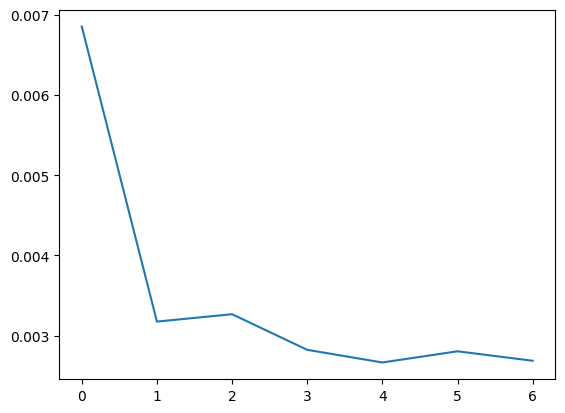

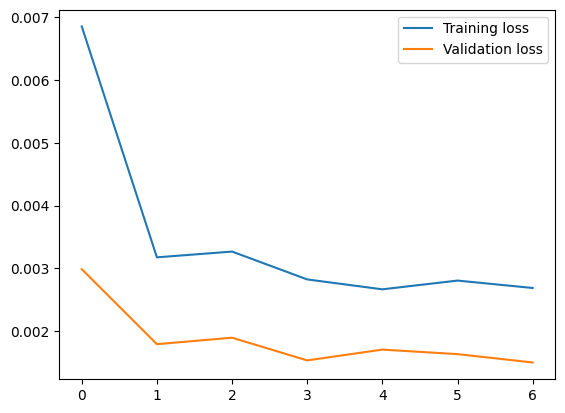

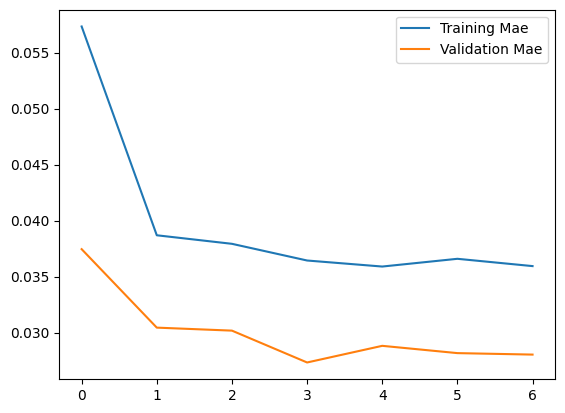

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

113/113 [==============================] - 2s 9ms/step


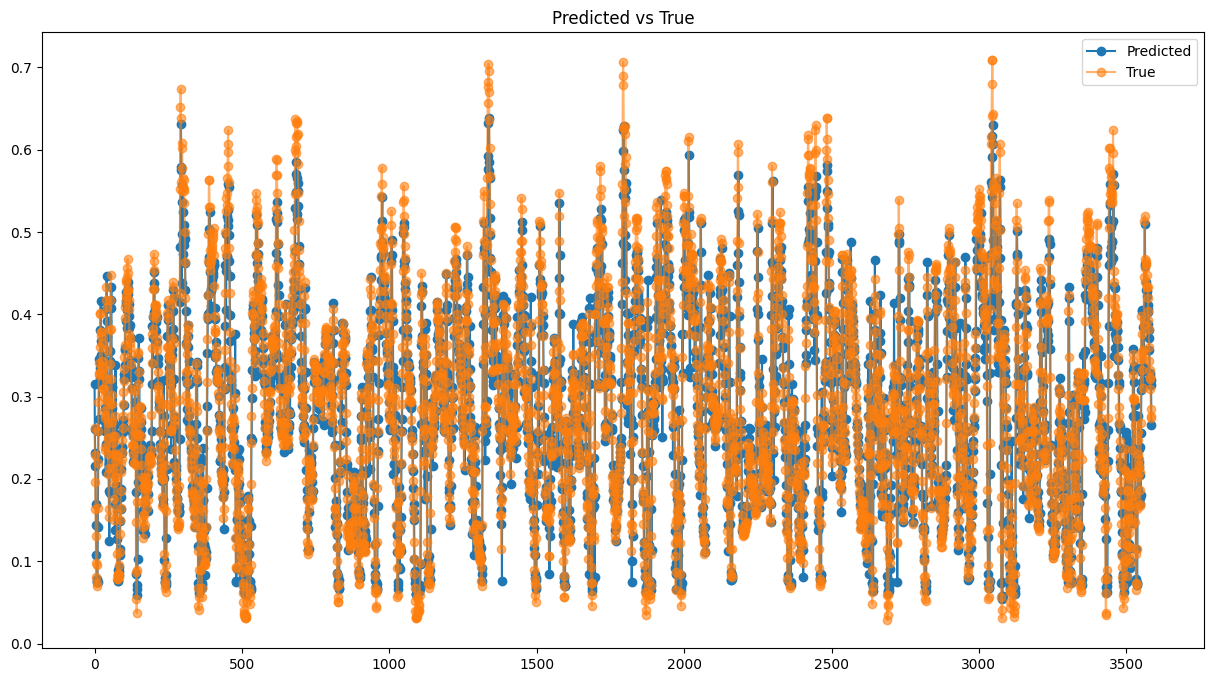

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03606662373827132,
 'mse': 0.04956393101753105,
 'rmse': 0.0024565832579105766}

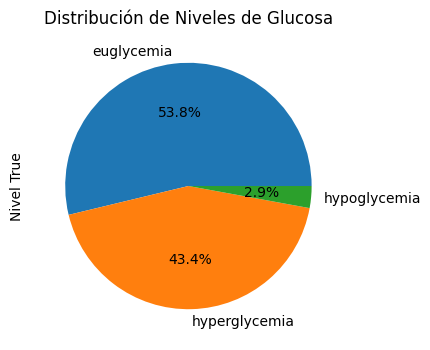

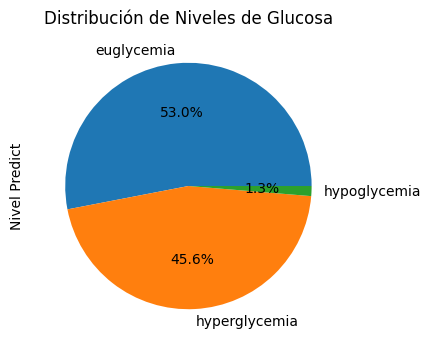

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,160.454545,euglycemia,185.173477,hyperglycemia
1,145.363636,euglycemia,159.837326,euglycemia
2,130.272727,euglycemia,146.766159,euglycemia
3,115.181818,euglycemia,139.274979,euglycemia
4,100.090909,euglycemia,117.858353,euglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


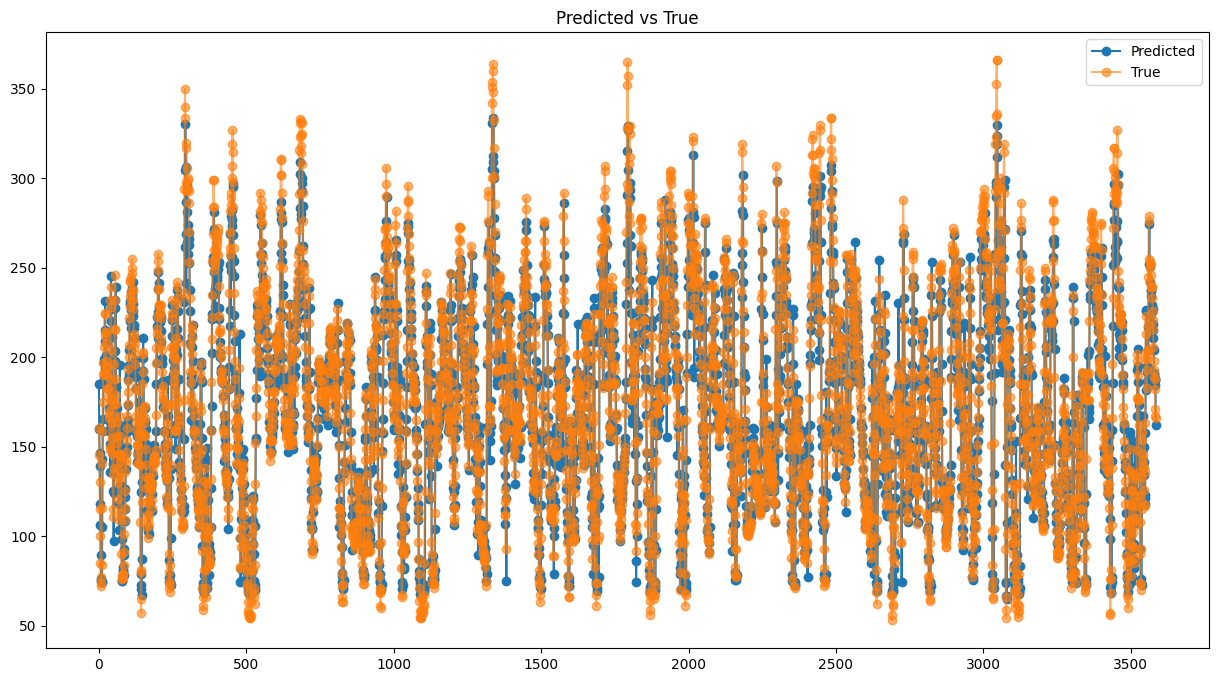

{'mae': 16.59064712521257,
 'mse': 22.799408340165773,
 'rmse': 519.8130206616206}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,160.454545,185.173477
2023-01-01 00:15:00,145.363636,159.837326
2023-01-01 00:30:00,130.272727,146.766159
2023-01-01 00:45:00,115.181818,139.274979
2023-01-01 01:00:00,100.090909,117.858353
...,...,...
2023-02-07 07:15:00,188.000000,188.237564
2023-02-07 07:30:00,182.000000,187.176483
2023-02-07 07:45:00,171.000000,187.114716
2023-02-07 08:00:00,167.000000,184.449356


AP, BE, EP: (0.8836820083682009, 0.0800557880055788, 0.03626220362622036)


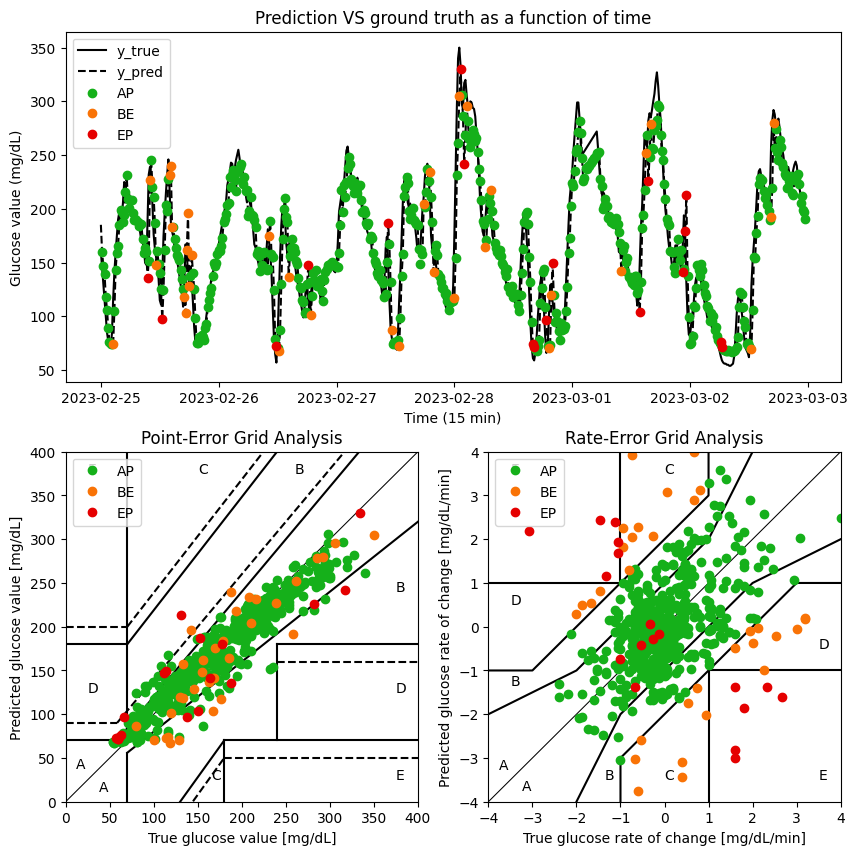

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)